# cifar100模型通道上的参数分布
## ViT-b16

In [1]:
%cd /home/zxy/SSF
import sys
import os
import torch
import timm
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint,\
    convert_splitbn_model, model_parameters
from models import vision_transformer, swin_transformer, convnext, as_mlp
import numpy as np

import matplotlib.pyplot as plt


/home/zxy/SSF


/home/zxy/miniconda3/envs/ssfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME="vit_base_patch16_224_in21k"
MODEL_PATH=""
METHOD_NAME="ssf"
origin='/data/hjy/SSF/origin.pth.tar'
ssf='/data/hjy/SSF/baseline-ssf-93.88.pth.tar'
pruned_ssf='/data/hjy/SSF/rec=0.7-epoch279.pth.tar'
NUM_CLASSES=100

In [5]:
def model_ini(path):
    model = create_model(
        MODEL_NAME,
        pretrained=True,
        num_classes=NUM_CLASSES,
        drop_rate=0.0,
        drop_path_rate=0.0,
        drop_block_rate=None,
        global_pool=None,
        bn_momentum=None,
        bn_eps=None,
        scriptable=False,
        checkpoint_path='',
        tuning_mode=METHOD_NAME)
    resume_epoch = resume_checkpoint(
        model, path,
        optimizer=None,
        loss_scaler=None,
        log_info=True)
    return model

def ckpt_parser(path):
    ckpt = torch.load(path, map_location='cpu')
    state_dict=ckpt['state_dict']
    return state_dict

## 验证ckpt_parser的准确性

In [77]:
originm=ckpt_parser(origin)
p1=model_ini(ssf)
p2=ckpt_parser(ssf)

In [80]:
total, pruned = 0, 0
sum=0
para=[]
for name, param in p1.named_parameters():
    sum+=1
    # print(param.data.detach().cpu().numpy().ndim)
    # para.append(param.data.detach().cpu().numpy().reshape(-1))
    if 'ssf_scale' in name: # or 'ssf_shift' in name:
        total += param.numel()
        pruned += (torch.abs(param.data) < 0.01).sum().item()
    else :
        para.append(param.data.detach().cpu().numpy().reshape(-1))
pruned = pruned / total
mnp=np.hstack(para)
print(mnp.shape)
print(np.mean(mnp))
print(np.var(mnp))
print(pruned)
print(sum)

(85978468,)
-0.00045428143
0.005412502
0.0
300


In [81]:
total, pruned = 0, 0
sum=0
para=[]
for name, param in p2.items():
    sum+=1
    # para.append(param.data.detach().cpu().numpy().reshape(-1))
    if 'ssf_scale' in name: # or 'ssf_shift' in name:
        total += param.numel()
        pruned += (torch.abs(param.data) < 0.01).sum().item()
    else:
        para.append(param.data.detach().cpu().numpy().reshape(-1))
pruned = pruned / total
mnp=np.hstack(para)
print(mnp.shape)
print(np.mean(mnp))
print(np.var(mnp))
print(pruned)
print(sum)

(85978468,)
-0.00045428143
0.005412502
0.0
300


## 数据处理

In [6]:
originm=ckpt_parser(origin)
ssfm=ckpt_parser(ssf)
ssfp=ckpt_parser(pruned_ssf)

Origin------------------------------------
cls_token                     mean=    0.02	mean_abs=    0.15	num=      768
pos_embed                     mean=   -0.00	mean_abs=    0.12	num=   151296
patch_embed.proj.weight       mean=    0.00	mean_abs=    0.01	num=   589824
patch_embed.proj.bias         mean=   -0.01	mean_abs=    0.07	num=      768
blocks.0.norm1.weight         mean=    0.48	mean_abs=    0.48	num=      768
blocks.0.norm1.bias           mean=    0.00	mean_abs=    0.07	num=      768
blocks.0.attn.qkv.weight      mean=    0.00	mean_abs=    0.02	num=  1769472
blocks.0.attn.qkv.bias        mean=   -0.03	mean_abs=    0.44	num=     2304
blocks.0.attn.proj.weight     mean=    0.00	mean_abs=    0.01	num=   589824
blocks.0.attn.proj.bias       mean=    0.00	mean_abs=    0.16	num=      768
blocks.0.norm2.weight         mean=    1.49	mean_abs=    1.49	num=      768
blocks.0.norm2.bias           mean=    0.01	mean_abs=    0.12	num=      768
blocks.0.mlp.fc1.weight       mean=   -0.00	m

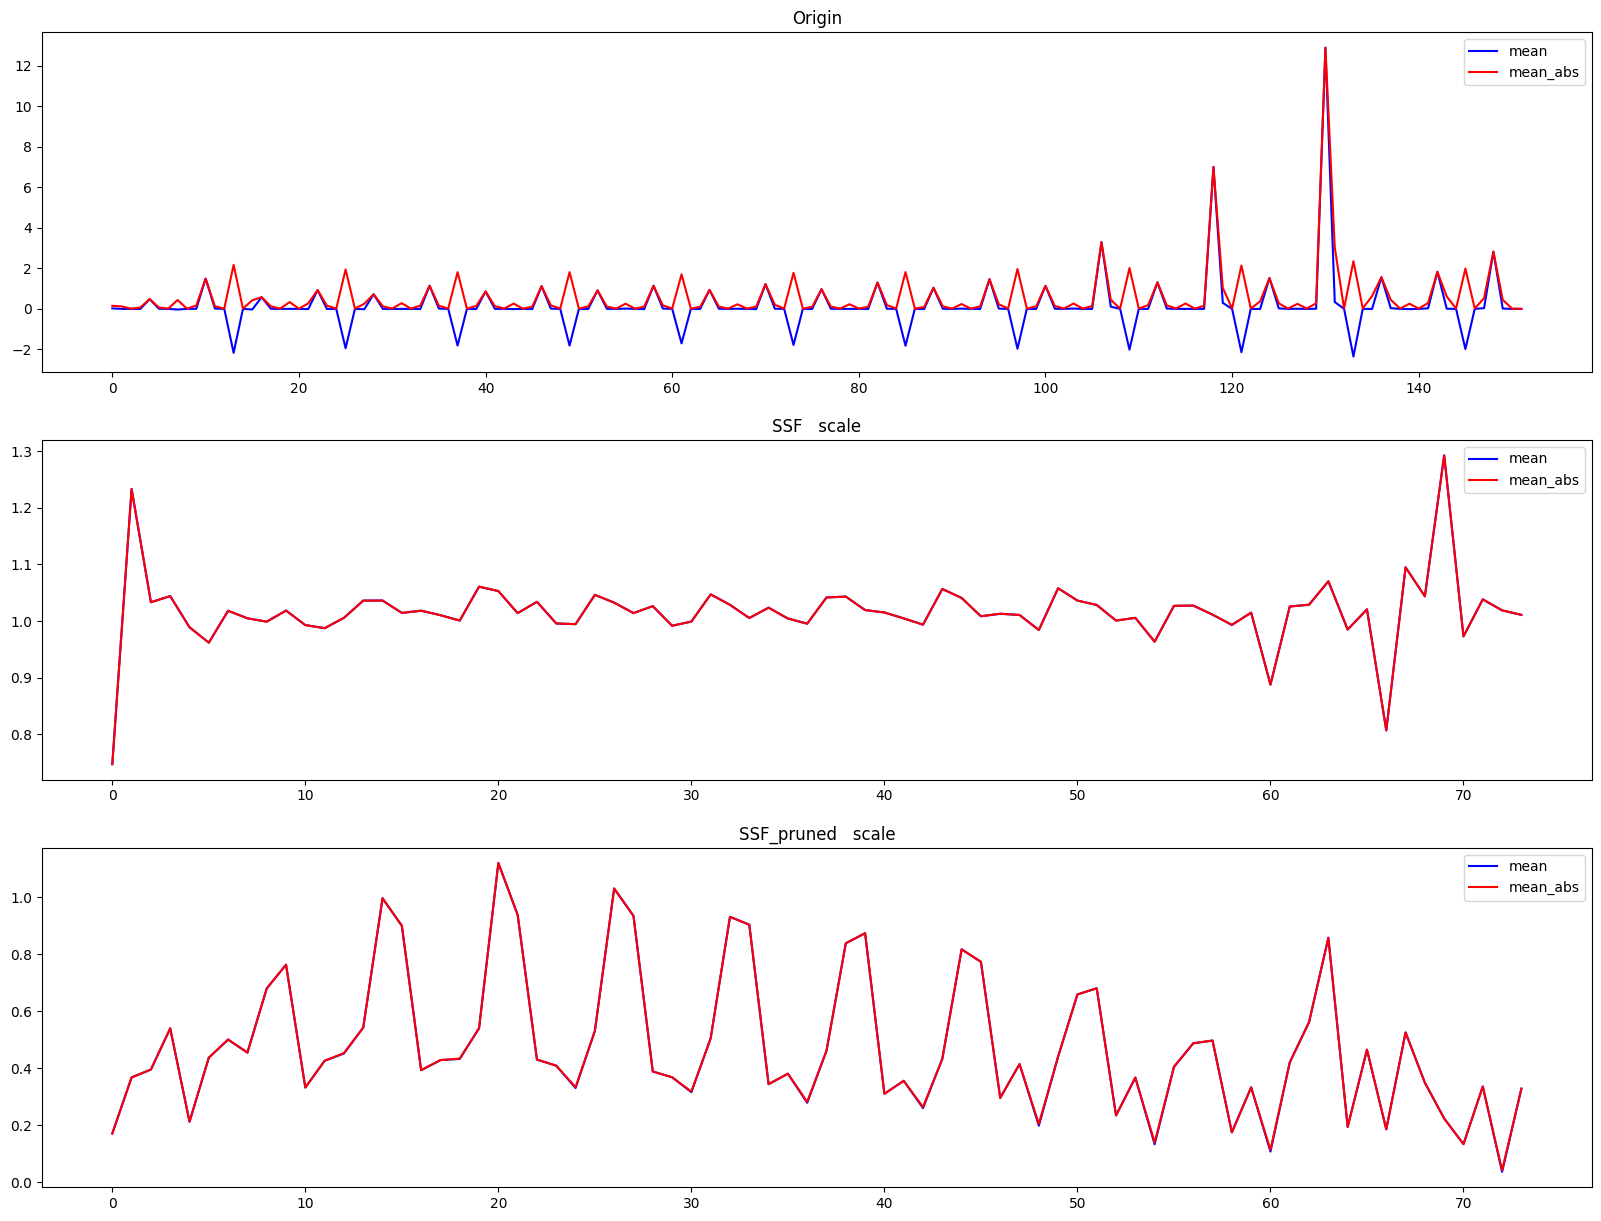

In [16]:
print('Origin------------------------------------')
mean=[]
mean_abs=[]
for name,data in originm.items():
    if 'ssf' not in name:
        data_np=data.data.detach().cpu().numpy()
        data_abs=np.abs(data_np)
        mean.append(np.mean(data_np))
        mean_abs.append(np.mean(data_abs))
        # mean.append(np.log(np.mean(data_np)/50+1))
        # mean_abs.append(np.log(np.mean(data_abs)/50+1))
        print(f'{name:30}mean={np.mean(data_np):8.2f}\tmean_abs={np.mean(data_abs):8.2f}\tnum={data.numel():9}')


plt.figure(figsize=(20,15))
plt.subplot(311)
data_x=[i for i in range(len(mean))]
# plt.scatter(data_x,mean,s=2,color='blue')
# plt.scatter(data_x,mean_abs,s=2,color='red')
plt.plot(data_x,mean,color='blue')
plt.plot(data_x,mean_abs,color='red')
plt.title('Origin')
plt.legend(['mean','mean_abs'],loc='upper right')

print('SSF  scale---------------------------------')
mean=[]
mean_abs=[]
for name,data in ssfm.items():
    if 'ssf_scale' in name:
        data_np=data.data.detach().cpu().numpy()
        data_abs=np.abs(data_np)
        mean.append(np.mean(data_np))
        mean_abs.append(np.mean(data_abs))
        # mean.append(np.log(np.mean(data_np)/50+1))
        # mean_abs.append(np.log(np.mean(data_abs)/50+1))
        print(f'{name:30}mean={np.mean(data_np):8.2f}\tmean_abs={np.mean(data_abs):8.2f}\tnum={data.numel():9}')

plt.subplot(312)
data_x=[i for i in range(len(mean))]
# plt.scatter(data_x,mean,s=2,color='blue')
# plt.scatter(data_x,mean_abs,s=2,color='red')
plt.plot(data_x,mean,color='blue')
plt.plot(data_x,mean_abs,color='red')
plt.title('SSF   scale')
plt.legend(['mean','mean_abs'],loc='upper right')

print('SSF_pruned   scale------------------------')
mean=[]
mean_abs=[]
for name,data in ssfp.items():
    if 'ssf_scale'  in name:
        data_np=data.data.detach().cpu().numpy()
        data_abs=np.abs(data_np)
        mean.append(np.mean(data_np))
        mean_abs.append(np.mean(data_abs))
        # mean.append(np.log(np.mean(data_np)/50+1))
        # mean_abs.append(np.log(np.mean(data_abs)/50+1))
        print(f'{name:30}mean={np.mean(data_np):8.2f}\tmean_abs={np.mean(data_abs):8.2f}\tnum={data.numel():9}')


plt.subplot(313)
data_x=[i for i in range(len(mean))]
# plt.scatter(data_x,mean,s=2,color='blue')
# plt.scatter(data_x,mean_abs,s=2,color='red')
plt.plot(data_x,mean,color='blue')
plt.plot(data_x,mean_abs,color='red')
plt.title('SSF_pruned   scale')
plt.legend(['mean','mean_abs'],loc='upper right')
        

## Something

In [ ]:
sum=0
n=0
for name,data in originm.items():
    # print(type(data))
    # print(data.shape)
    # break
    if 'ssf' not in name:
        n+=1
        print(f'{name:25}\t\t{data.numel():10}')
    sum+=data.numel()
    # n+=1
print(sum)
print(n)

cls_token                		       768
pos_embed                		    151296
patch_embed.proj.weight  		    589824
patch_embed.proj.bias    		       768
blocks.0.norm1.weight    		       768
blocks.0.norm1.bias      		       768
blocks.0.attn.qkv.weight 		   1769472
blocks.0.attn.qkv.bias   		      2304
blocks.0.attn.proj.weight		    589824
blocks.0.attn.proj.bias  		       768
blocks.0.norm2.weight    		       768
blocks.0.norm2.bias      		       768
blocks.0.mlp.fc1.weight  		   2359296
blocks.0.mlp.fc1.bias    		      3072
blocks.0.mlp.fc2.weight  		   2359296
blocks.0.mlp.fc2.bias    		       768
blocks.1.norm1.weight    		       768
blocks.1.norm1.bias      		       768
blocks.1.attn.qkv.weight 		   1769472
blocks.1.attn.qkv.bias   		      2304
blocks.1.attn.proj.weight		    589824
blocks.1.attn.proj.bias  		       768
blocks.1.norm2.weight    		       768
blocks.1.norm2.bias      		       768
blocks.1.mlp.fc1.weight  		   2359296
blocks.1.mlp.fc1.bias    		      3072
blocks.1.mlp

In [40]:
ssf_scale,ssf_shift={},{}
for name, para in model.named_parameters():
    if "ssf_scale" in name:
        ssf_scale[name]=para.data.detach().cpu().numpy()
    elif "ssf_shift" in name:
        ssf_shift[name]=para.data.detach().cpu().numpy()
    else:
        pass

In [6]:
# show basic info of ssf_scale and ssf_shift:
print("Length: ",len(ssf_scale),"\t",len(ssf_shift))
print("SSF_SCALE:")
for k in ssf_scale:
    print(k,ssf_scale[k].shape)
print("SSF_SHIFT:")
for k in ssf_shift:
    print(k,ssf_shift[k].shape)

Length:  74 	 74
SSF_SCALE:
ssf_scale_1 (768,)
patch_embed.ssf_scale_1 (768,)
blocks.0.ssf_scale_1 (768,)
blocks.0.ssf_scale_2 (768,)
blocks.0.attn.ssf_scale_1 (2304,)
blocks.0.attn.ssf_scale_2 (768,)
blocks.0.mlp.ssf_scale_1 (3072,)
blocks.0.mlp.ssf_scale_2 (768,)
blocks.1.ssf_scale_1 (768,)
blocks.1.ssf_scale_2 (768,)
blocks.1.attn.ssf_scale_1 (2304,)
blocks.1.attn.ssf_scale_2 (768,)
blocks.1.mlp.ssf_scale_1 (3072,)
blocks.1.mlp.ssf_scale_2 (768,)
blocks.2.ssf_scale_1 (768,)
blocks.2.ssf_scale_2 (768,)
blocks.2.attn.ssf_scale_1 (2304,)
blocks.2.attn.ssf_scale_2 (768,)
blocks.2.mlp.ssf_scale_1 (3072,)
blocks.2.mlp.ssf_scale_2 (768,)
blocks.3.ssf_scale_1 (768,)
blocks.3.ssf_scale_2 (768,)
blocks.3.attn.ssf_scale_1 (2304,)
blocks.3.attn.ssf_scale_2 (768,)
blocks.3.mlp.ssf_scale_1 (3072,)
blocks.3.mlp.ssf_scale_2 (768,)
blocks.4.ssf_scale_1 (768,)
blocks.4.ssf_scale_2 (768,)
blocks.4.attn.ssf_scale_1 (2304,)
blocks.4.attn.ssf_scale_2 (768,)
blocks.4.mlp.ssf_scale_1 (3072,)
blocks.4.mlp.s

74


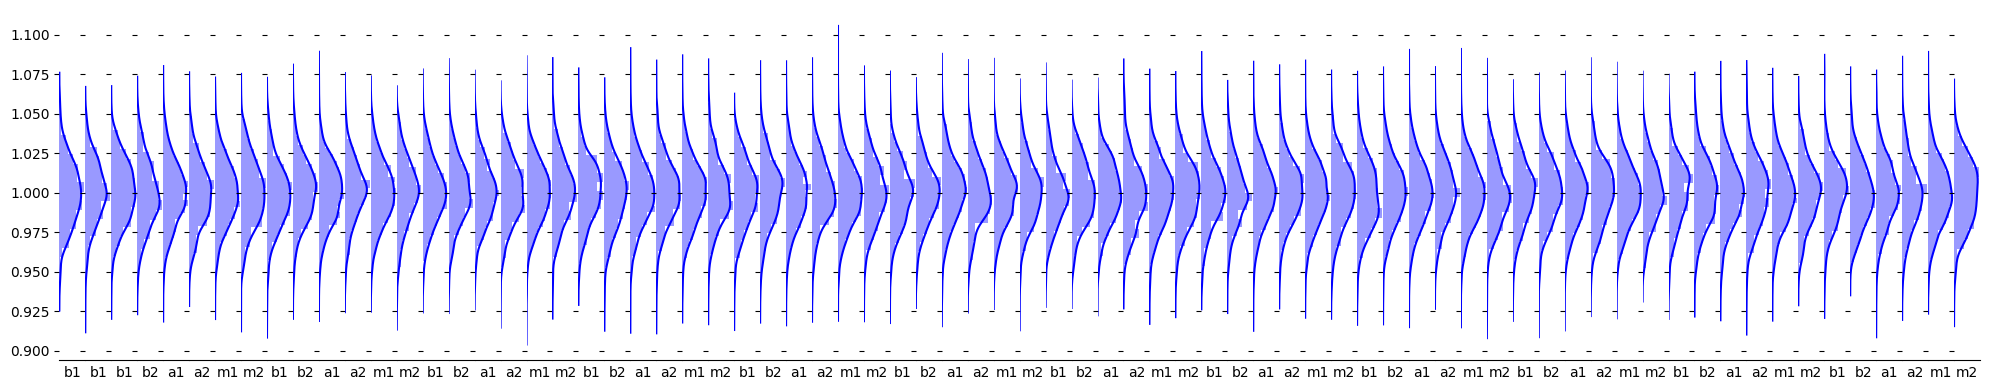

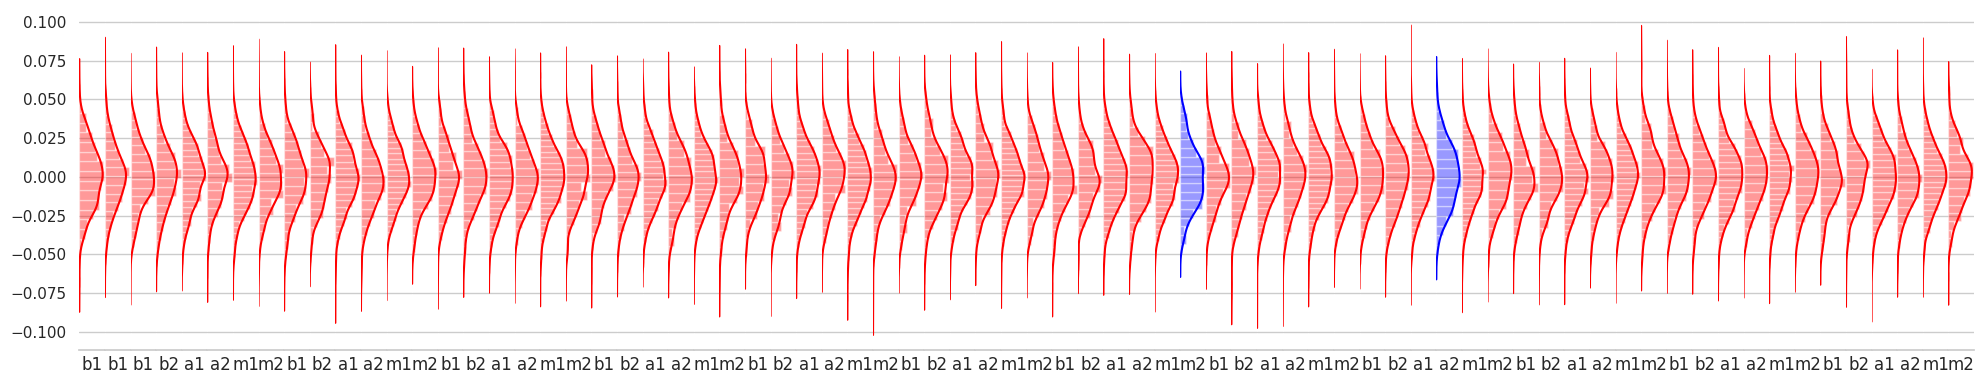

MAX Scale:  1.0934325
MIN Scale:  0.9159811
MAX Shift:  0.084781915
MIN Shift:  -0.085590504


In [30]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.models as models

def draw6(row1,name=None):
    data=row1
    arr = data
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    fig, axs = plt.subplots(ncols=num_rows, nrows=1, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for i in range(num_rows):
        # sns.histplot(y=arr[i], ax=axs[i], kde=True, stat="density")
        # sns.distplot(arr[i], ax=axs[i], kde=True, stat="density",hist_kws={'range': (0.0, 0.2)})
        color="blue"
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            color="red"
        sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color)
        # sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color,\
        #     hist_kws={'range': ran},kde_kws={'clip': ran})
        # sns.histplot(data, clip=(0, 10))
        axs[i].set_xticks([])
        # axs[i].set_xlabel(f"{i+1}")
        label=""
        if 'attn' in name[i]:
            label+="a"
        elif 'mlp' in name[i]:
            label+="m"
        else:
            label+="b"
        label+=name[i].split("_")[-1]
        axs[i].set_xlabel(label)
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
ssf_scale_list,ssf_shift_list,ssf_scale_name,ssf_shift_name=[],[],[],[]
for name, para in model.named_parameters():
    if "ssf_scale" in name:
        ssf_scale_list.append(para.data.detach().cpu().numpy())
        ssf_scale_name.append(name)
    elif "ssf_shift" in name:
        ssf_shift_list.append(para.data.detach().cpu().numpy())
        ssf_shift_name.append(name)
    else:
        pass
print(len(ssf_scale_name))
draw6(ssf_scale_list,ssf_scale_name)
draw6(ssf_shift_list,ssf_shift_name)
print("MAX Scale: ", max([s.max() for s in ssf_scale_list]))
print("MIN Scale: ", min([s.min() for s in ssf_scale_list]))
print("MAX Shift: ", max([s.max() for s in ssf_shift_list]))
print("MIN Shift: ", min([s.min() for s in ssf_shift_list]))

In [8]:
# print("MIN Scale: ", min([s.min() for s in ssf_scale_list]))
# print("MAX Shift: ", max([s.max() for s in ssf_shift_list]))
sc_num=0
sc_pnm=0
for i,(sc,sh) in enumerate(zip(ssf_scale_list,ssf_shift_list)):
    # select indexes from sc, where abs value is less than 0.02
    # indexes=np.where(np.abs(sc)<0.02)
    indexes=np.argwhere(np.abs(sc)<0.01)
    subsc=np.take(sc,indexes)
    sc_pnm+=len(subsc)
    sc_num+=len(sc)
    subsh=np.take(sh,indexes)
    
    # subsh=np.take(sh,indexes)
    print("{:.2f} Layer {}:\t{}/{}\t{:.2f}%".format(np.abs(subsh).mean(), i,len(subsc),len(sc),len(subsc)/len(sc)*100))
print("Total:\t{}/{}\t{:.2f}%".format(sc_pnm,sc_num,sc_pnm/sc_num*100))

nan Layer 0:	0/768	0.00%
0.02 Layer 1:	2/768	0.26%
0.00 Layer 2:	266/768	34.64%
0.01 Layer 3:	246/768	32.03%
0.00 Layer 4:	576/2304	25.00%
nan Layer 5:	0/768	0.00%
0.00 Layer 6:	13/3072	0.42%
nan Layer 7:	0/768	0.00%
0.00 Layer 8:	78/768	10.16%
0.01 Layer 9:	53/768	6.90%
0.00 Layer 10:	358/2304	15.54%
nan Layer 11:	0/768	0.00%
0.00 Layer 12:	23/3072	0.75%
nan Layer 13:	0/768	0.00%
0.00 Layer 14:	26/768	3.39%
0.03 Layer 15:	16/768	2.08%
0.00 Layer 16:	46/2304	2.00%
nan Layer 17:	0/768	0.00%
nan Layer 18:	0/3072	0.00%
nan Layer 19:	0/768	0.00%
0.01 Layer 20:	7/768	0.91%
0.00 Layer 21:	3/768	0.39%
0.00 Layer 22:	58/2304	2.52%
nan Layer 23:	0/768	0.00%
nan Layer 24:	0/3072	0.00%
nan Layer 25:	0/768	0.00%
0.00 Layer 26:	11/768	1.43%
0.03 Layer 27:	2/768	0.26%
0.00 Layer 28:	84/2304	3.65%
nan Layer 29:	0/768	0.00%
nan Layer 30:	0/3072	0.00%
nan Layer 31:	0/768	0.00%
0.00 Layer 32:	15/768	1.95%
0.01 Layer 33:	5/768	0.65%
0.00 Layer 34:	88/2304	3.82%
nan Layer 35:	0/768	0.00%
nan Layer 36:	0/3

In [9]:
# def print_outler(row1,name=None):
#     data=row1
#     arr = data
#     up_mean=np.mean(np.array([a.max() for a in arr]))
#     lw_mean=np.mean(np.array([a.min() for a in arr]))
#     num_rows = len(arr)
#     lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
#     ran=(lw,up_mean*1.5)
#     for i in range(len(row1)):
#         if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
#             print(name[i])
# print_outler(ssf_scale_list,ssf_scale_name)
# print_outler(ssf_shift_list,ssf_shift_name)
